# Using doNd functions for performing measurements

This example notebook contains simple cases in which the `doNd` utilities of QCoDeS can be used to perform experiments. The `doNd` functions are generic wrappers of QCoDeS measurements in zero, one and two dimensions. In what follows, we shall provide the most basic functionalities and leave more detailed practices to the user. In particular, we shall not concern about single point measurements.

In [1]:
from functools import partial
import os

import numpy as np

from qcodes.utils.dataset.doNd import do1d, do2d, plot
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/201229-15582-qcodes.log


In [2]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doND.db')
initialise_or_create_database_at(tutorial_db_path)
load_or_create_experiment("doNd-tutorial", sample_name="no sample")

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 320.74it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 816.33it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 121.70it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 781.79it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 510.19it/s]

doNd-tutorial#no sample#1@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doND.db
------------------------------------------------------------------------------------

First we setup two dummy instruments to have something to measure. The dmm is setup to generate an output depending on the values set on the dac simulating a real experiment.

In [3]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

Now let us use `do1d` function to make a simple one dimensional sweep. 

In [4]:
result = do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2)

Starting experimental run with id: 1. 


By default the `dond` functions  will not generate a plot of the output. This can be changed in one of two ways. For each individual call to dond one can set the value of the keyword argument `do_plot` to True. Alternatively one can globally set the value of the setting `dataset.dond_plot` in the `qcodesrc.json` configuration file. In the examples below we will often set `do_plot` to True to illustrate how the dond functions work.

Note that for most usecases we recommed using [Plottr](https://github.com/toolsforexperiments/plottr/) for live plotting. See [How to use plottr with QCoDeS for live plotting](../plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb) for an introduction to Plottr.

Starting experimental run with id: 2. 


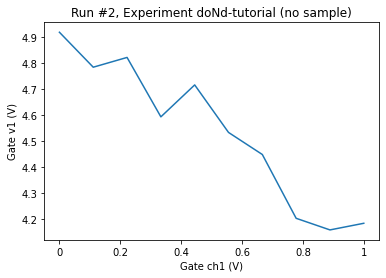

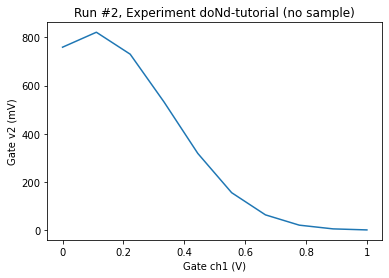

In [5]:
result = do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2, do_plot = True)

Now, let us have a two dimensional sweep over gate voltages:

In [6]:
result = do2d(dac.ch1, -1, 1, 20, 0.01, dac.ch2, -1, 1, 20, 0.01, dmm.v1, dmm.v2)

Starting experimental run with id: 3. 


Starting experimental run with id: 4. 


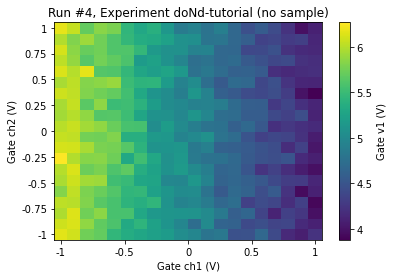

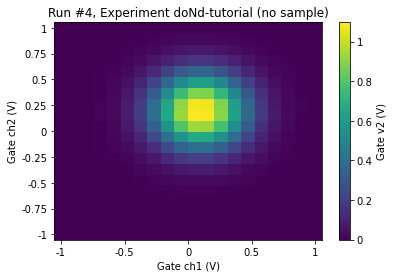

In [7]:
result = do2d(dac.ch1, -1, 1, 20, 0.01, dac.ch2, -1, 1, 20, 0.01, dmm.v1, dmm.v2, do_plot = True)

Note that `do_plot = True` is the default value and we only added it for the sake of explicitness. The `doNd` utility, in fact, uses an internal public function called `plot` to handle data visualization, which by default saves the figures in both pdf and png formats, as well. Therefore, users, if needed, can only do their measurements with the option `do_plot = False` and then pass the relevant dataset to `plot` when visualization is necessary and choose to save figures in a desired format.

Internally, the `doNd` functions return a tuple consists of the dataset obtained in the measurement, the boolean value correponding to `do_plot` and a callable which checks whether the experiment is interupted by the user. Thus, if the `plot` shall be used explicitly after the measurement, one has to pass the first argument of the return value. 

In [8]:
result_1d = do1d(dac.ch1, 0, 0.25, 10, 0.01, dmm.v1, dmm.v2, do_plot = False)

Starting experimental run with id: 5. 


In [9]:
result_2d = do2d(dac.ch1, -0.6, 0.6, 20, 0.01, dac.ch2, -0.6, 0.6, 20, 0.01, dmm.v1, dmm.v2, do_plot = False)

Starting experimental run with id: 6. 


(results #5@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doND.db
 ---------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #5, Experiment doNd-tutorial (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #5, Experiment doNd-tutorial (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v2 (mV)'>],
 [None, None])

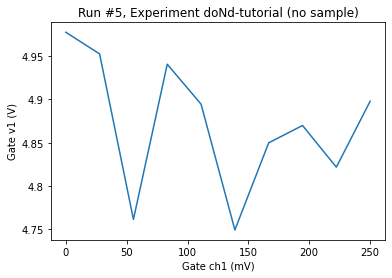

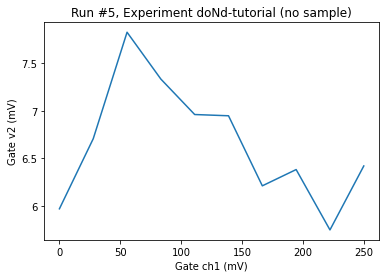

In [10]:
plot(result_1d[0], save_pdf = False, save_png =True)

(results #6@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doND.db
 ---------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #6, Experiment doNd-tutorial (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>,
  <AxesSubplot:title={'center':'Run #6, Experiment doNd-tutorial (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>],
  <matplotlib.colorbar.Colorbar at 0x7f39e1f85c10>])

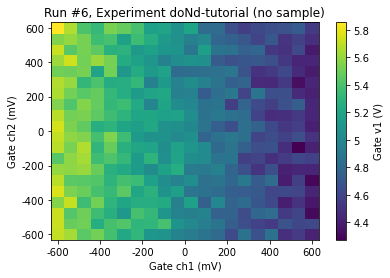

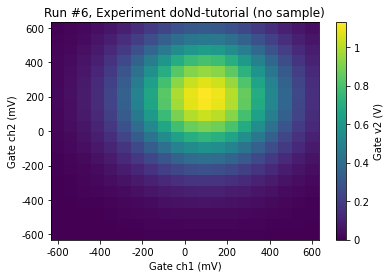

In [11]:
plot(result_2d[0], save_pdf = True, save_png = False)